### Computer Vision Final Project
Michael Edenzon and Griffin Hiers

127
(592, 896, 3)


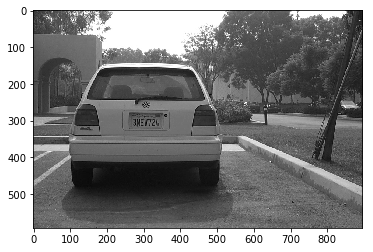

In [42]:
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt
import os

%matplotlib inline

# accepts image filename as string
# reads and returns image
def load(filename):
    return cv2.imread(filename)

# accepts an image
# draws image
def draw(image,title='',axis=True,gray=True,cmap=''):
    plt.figure()
    plt.title(title)
    if gray or cmap != '':
        if gray:
            plt.imshow(image,cmap='gray')
        else:
            plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(image)
        plt.show()
    if not axis:
        plt.axis('off')

# accepts a list of images
# displays images horizontally
def display(images,gray=True):
    figure = plt.figure()
    for i in xrange(len(images)):
        figure.add_subplot(1,len(images),i+1)
        if gray:
            plt.imshow(images[i],cmap='gray')
        else:
            plt.imshow(images[i])
        plt.axis( 'off' )
        
# accepts an image
# returns opencv contours
def findContours(image):
    img = image
    #img = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    img2, contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    return contours

# accepts opencv contours
# converts to image and draws contours
def drawContours(contours,mask,stroke=10):
    draw(imageFromContours(contours,mask,stroke))
    
# accepts opencv contours
# returns contours as opencv image
def imageFromContours(contours,img,stroke=5):
    return cv2.drawContours(np.zeros(img.shape,np.uint8),contours, -1,(255,0,0),stroke)

def maskFromContours(contours,img):
    return cv2.drawContours(np.zeros(img.shape,np.uint8),contours,-1,(255,255,255),cv2.FILLED)

# accepts image and threshold parameters
# returns threshold image
def thresh(image,threshVal,maxVal,threshType):
    ret,threshImg = cv2.threshold(image,threshVal,maxVal,threshType)
    return threshImg

# accepts contours and image shape
# returns contours as image scaled and centered in 200x200 frame
def formatContours(contours,image,pad=20):
    frame = image.shape
    bounds = cv2.boundingRect(contours)
    x,y,w,h = bounds
    stroke = 32
    img = aspectScale(image[y:y+h,x:x+w],200)
    return img

# accepts image
# returns image contours as image scaled and centered in 200x200 frame
def formatImage(image,stroke=3):
    contours = findContours(image)
    img = imageFromContours(contours[0],image.shape,stroke)
    img = aspectFill(image,contours[0])
    img = scale(image,200)
    return img

# accepts image with pixels 0-255
# returns image with pixels 0.0-1.0
def ones(image):
    return np.round(np.divide(image.astype(float),255))

# accepts images A and B
# displays the steps of taking the jaccard coefficient of A and B
def displayJ(A,B):
    n = np.multiply(A,B)
    u = np.subtract(np.add(A,B),n)
    display([A,B,n,u])

# load template images
filenames = os.listdir('dataset')
testImage = cv2.imread('dataset/' + filenames[2],0)

IMG_SHAPE = cv2.imread('dataset/' + filenames[1]).shape

images = []
def loadImages():
    for filename in filenames:
        images.append(cv2.imread('dataset/' + filename,0))
loadImages()
print len(images)

print(IMG_SHAPE)
draw(testImage)
#cv2.imwrite("powerpoint/0_original.jpg", testImage)

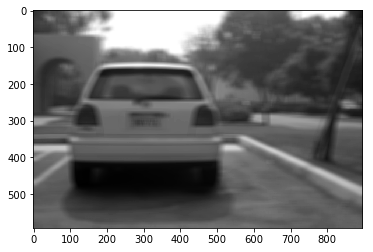

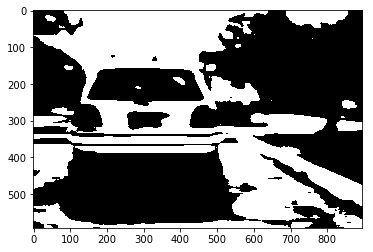

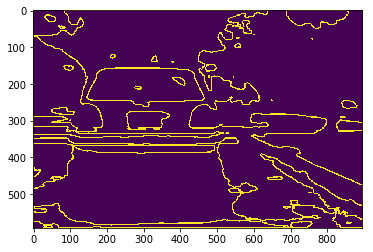

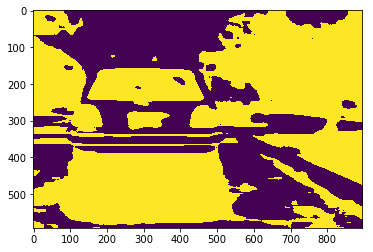

In [43]:
img0 = cv2.GaussianBlur(testImage, (23,11), 100)
draw(img0)

img1 = thresh(img0,100, 255, cv2.THRESH_BINARY)
draw(img1)

contours = findContours(img1)

img2 = imageFromContours(contours,img1,stroke=2)
draw(img2,gray=False)

img3 = maskFromContours(contours,img0)
temp = np.zeros(img3.shape)
img3 = cv2.bitwise_not(img3,temp)
draw(img3,gray=False)

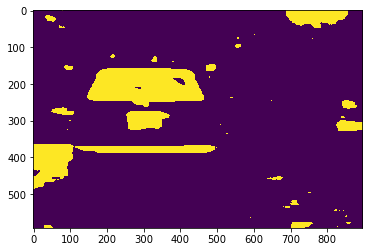

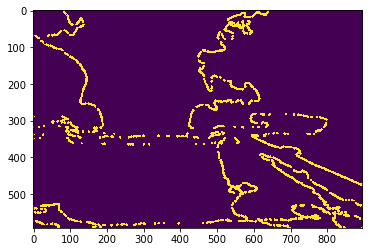

In [44]:
maxArea,index = None,0
for i in range(len(contours)):
    if i == 0:
        maxArea = cv2.contourArea(contours[i])
        index = i
    else:
        area = cv2.contourArea(contours[i])
        if area > maxArea:
            maxArea = area
            index = i
            
cnt = contours[index]
del contours[index]

img4 = maskFromContours(contours,img)
draw(img4,gray=False)
draw(imageFromContours(cnt,img0),gray=False)

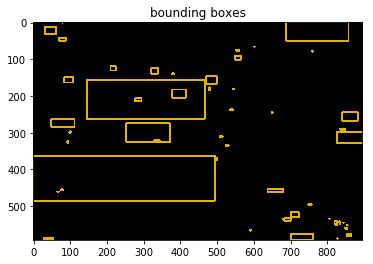

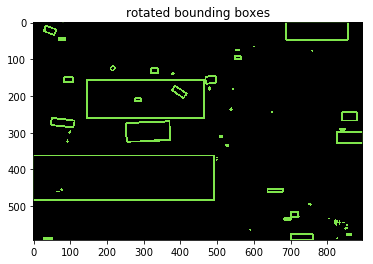

In [45]:
plateContour = None
for contour in contours:
    M = cv2.moments(contour)
    if (M['m00'] != 0) and (M['m10'] != 0) and (M['m01'] != 0):
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        if ((cx > 200) and (cx < 400)) and ((cy > 250) and (cy < 350)):
            plateContour = contour

blankImage = np.zeros(IMG_SHAPE)
for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    cv2.rectangle(blankImage,(x,y),(x+w,y+h),(0.9,0.7,0.0),4)
draw(blankImage,title='bounding boxes',gray=False)

blankImage2 = np.zeros(IMG_SHAPE)
for contour in contours:
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(blankImage2,[box],0,(0.5,0.9,0.3),4)
draw(blankImage2,title='rotated bounding boxes',gray=False)

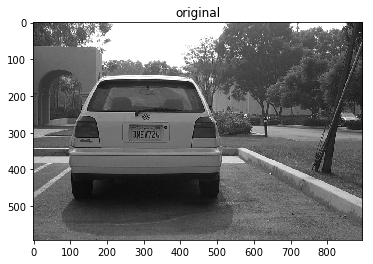

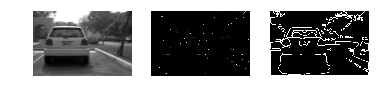

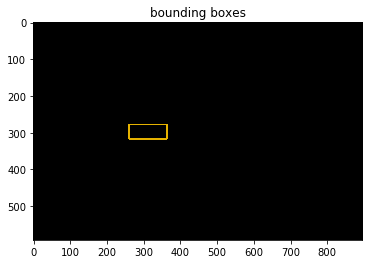

In [46]:
imageSet = []
originalImage = images[2]
img = originalImage
draw(img,title='original')

img = cv2.GaussianBlur(img, (19,11), 100)
imageSet.append(img)

img = thresh(img,85, 255, cv2.THRESH_BINARY)
imageSet.append(img)

contours = findContours(img)
imageSet.append(imageFromContours(contours,img))

display(imageSet)

def getLargeContours(contours,shape=IMG_SHAPE):
    largeContours = []
    for i in range(len(contours)):
        x,y,w,h = cv2.boundingRect(contours[i])
        ratio = cv2.contourArea(contours[i])/(shape[0]*shape[1])
        cnt_ratio = cv2.contourArea(contours[i]) / (w*h)
        if (ratio > 0.002) and (ratio < 0.01) and (cnt_ratio > 0.4) and (w > h):
            largeContours.append(contours[i])
    return largeContours

largeContours = getLargeContours(contours)
blankImage3 = np.zeros(IMG_SHAPE)

for i in range(len(largeContours)):
    x,y,w,h = cv2.boundingRect(largeContours[i])
    cv2.rectangle(blankImage3,(x,y),(x+w,y+h),(0.9,0.7,0.0),4)
draw(blankImage3,title='bounding boxes',gray=False)

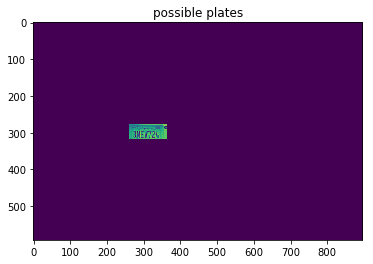

In [47]:
def aspectRatio(w,h):
    return float(w)/float(h)

blankImage4 = np.zeros(IMG_SHAPE)


possiblePlateContours = []
for i in range(len(largeContours)):
    x,y,w,h = cv2.boundingRect(largeContours[i])
    aspect = aspectRatio(w,h)
    if (aspect > 1.8) and (aspect < 3) and (w > h):
        cv2.rectangle(blankImage4,(x,y),(x+w,y+h),(0.9,0.7,0.0),4)
        possiblePlateContours.append(largeContours[i])

blankImage5 = np.zeros(originalImage.shape)
for contour in possiblePlateContours:
    x,y,w,h = cv2.boundingRect(contour)
    blankImage5[y:y+h,x:x+w] = originalImage[y:y+h,x:x+w]

draw(blankImage5,title='possible plates',gray=False)